# Graph Neural Networks

Graph Neural Networks (GNNs) are needed despite other architectures because traditional neural networks (like CNNs and RNNs) are designed for data structured in Euclidean spaces (e.g., images as 2D grids, text as sequences). However, a vast amount of real-world data is inherently non-Euclidean and represented as graphs, where entities (nodes) are connected by relationships (edges).

<p style='text-align:center;'><img src='https://miro.medium.com/v2/resize:fit:1400/1*omTgS4Ex2yVEztodzf-r-g.png'></p>

A GNN processes graph-structured data where we have nodes (entities) connected by edges (relationships). The key idea is that each node's representation should be influenced by its neighbors in the graph.

### Message Passing Framework:

+ **Aggregate**: Collect information from neighboring nodes
+ **Update**: Combine neighbor information with node's own features
+ **Transform**: Apply neural network layers

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj
from sklearn.manifold import TSNE

## Dataset: Cora

+ A citation network of scientific papers
+ Nodes: 2,708 research papers
+ Edges: Citation relationships (5,429 edges)
+ Features: 1,433-dimensional bag-of-words vectors
+ Task: Classify papers into 7 research areas

In [3]:
def load_dataset():
    print('..Loading Dataset../n')
    dataset = Planetoid(root = 'data/Cora', name='Cora')
    data = dataset[0]
    print(f'Dataset                   : {dataset}')
    print(f'Number of graphs          : {len(dataset)}')
    print(f'Number of nodes           : {data.x.shape[0]}')
    print(f'Number of edges           : {data.edge_index.shape[1]}')
    print(f'Number of node features   : {data.x.shape[1]}')
    print(f'Number of classes         : {dataset.num_classes}')
    print(f'Number of training nodes  : {data.train_mask.sum()}')
    print(f'Number of validation nodes: {data.val_mask.sum()}')
    print(f'Number of test nodes      : {data.test_mask.sum()}')
    print()
    return data, dataset.num_classes

## Model Architecture Breakdown
+ The model takes node features and edge connections as input
+ Applies average aggregation to collect neighbor information
+ Uses linear layers to transform features
+ Outputs class predictions

<p style='text-align:center;'><img src='https://miro.medium.com/v2/resize:fit:1400/1*vVJpsgCHidpXFnS-v9Pyzw.png'></p>

In [4]:
class GNN(nn.Module):
    def __init__(self, inp_dim, hidden_dim, out_dim, num_layers=2):
        super(GNN, self).__init__()
        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(inp_dim, hidden_dim))
        for _ in range(num_layers-2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, out_dim))
        self.dropout = nn.Dropout(0.5)

    def agg_neighbors(self, x, edge_index):
        # x : (num_nodes, feature_dim)
        # edge_index : (2, num_edge)
        device = x.device
        num_nodes = x.shape[0]
        agg = torch.zeros_like(x)
        neighbor_count = torch.zeros(num_nodes, dtype=torch.float, device = device)
        src_nodes = edge_index[0]
        tgt_nodes = edge_index[1]

        # for each node add src node features to tgt node's agg
        for i in range(edge_index.size(1)):
            src = src_nodes[i]
            tgt = tgt_nodes[i]

            # adding src node features to tgt node's agg
            agg[tgt] += x[src]
            neighbor_count[tgt] += 1

        neighbor_count = torch.clamp(neighbor_count, min = 1.0)
        agg = agg/neighbor_count.unsqueeze(1)
        return agg

    def forward(self, x, edge_ind):
        # returns embeddings after GNN processing
        for i, layer in enumerate(self.layers):
            agg_feat = self.agg_neighbors(x, edge_ind)
            x = agg_feat
            x = layer(x)
            if i < len(self.layers) - 1:
                x = F.relu(x)
                x = self.dropout(x)
        return x

In [5]:
def train(model, data, epochs=200):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    
    model.train()
    train_l = []
    val_accuracy = []
    print("..Training Model..\n")
    for epoch in range(epochs):
        optimizer.zero_grad()
        pred = model(data.x, data.edge_index)
        loss = loss_fn(pred[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            pred = pred.argmax(dim=1)
            val_acc = (pred[data.val_mask] == data.y[data.val_mask]).float().mean()
        model.train()
        train_l.append(loss.item())
        val_accuracy.append(val_acc.item())

    if epoch%20 == 19:
        print(f'Epoch {epoch+1}/{epochs},  Loss : {loss:.4f},  Val acc : {val_acc:.4f}')

    print('\n..Training Complete..\n')
    
    return model, train_l, val_accuracy

In [6]:
def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        embed = model(data.x, data.edge_index).argmax(dim=1)
        test_acc = (embed[data.test_mask] == data.y[test_mask]).float().mean()
        print(f'\nAccuracy on test set : {test_acc:.4f}\n')

In [7]:
def visualize_results(t_l, v_l):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(t_l)
    ax[0].set_title('Training Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].grid(True)

    ax[1].plot(t_l)
    ax[1].set_title('Validation accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

In [8]:
def visualize_embed(model, data, num_classes):
    model.eval()
    with torch.no_grad():
        embed = model(data.x, data.edge_index)
        tsne = TSNE(n_components=2)
        embed_2d = tsne.fit_transform(embed.cpu().numpy())
        plt.figure(figsize=(10, 8))
        colors = plt.cm.Set3(np.linspace(0,1,num_classes))

        for i in range(num_classes):
            mask = data.y.cpu().numpy() == i
            plt.scatter(embed_2d[mask, 0], embed_2d[mask, 1], c = [colors[i]], label=f'Class {i}', alpha=  0.85)
        plt.title('Node Embeddings plotted using Dimensionality reduction (t-sne)')
        plt.legend()
        plt.grid(True, alpha = 0.3)
        plt.show()

..Loading Dataset../n


Processing...
Done!


Dataset                   : Cora()
Number of graphs          : 1
Number of nodes           : 2708
Number of edges           : 10556
Number of node features   : 1433
Number of classes         : 7
Number of training nodes  : 140
Number of validation nodes: 500
Number of test nodes      : 1000

Number of parameter : 92231

Model Architecture:
GNN(
  (layers): ModuleList(
    (0): Linear(in_features=1433, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=7, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

..Training Model..

Epoch 200/200,  Loss : 0.0130,  Val acc : 0.7640

..Training Complete..



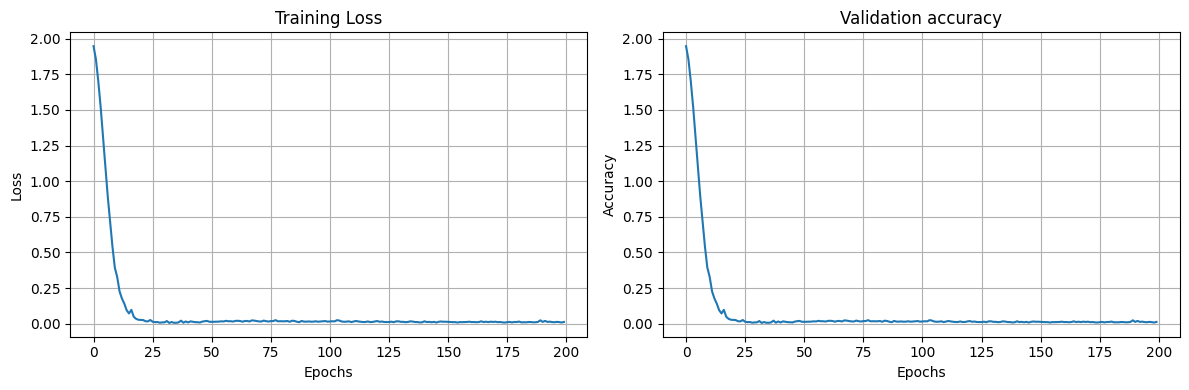

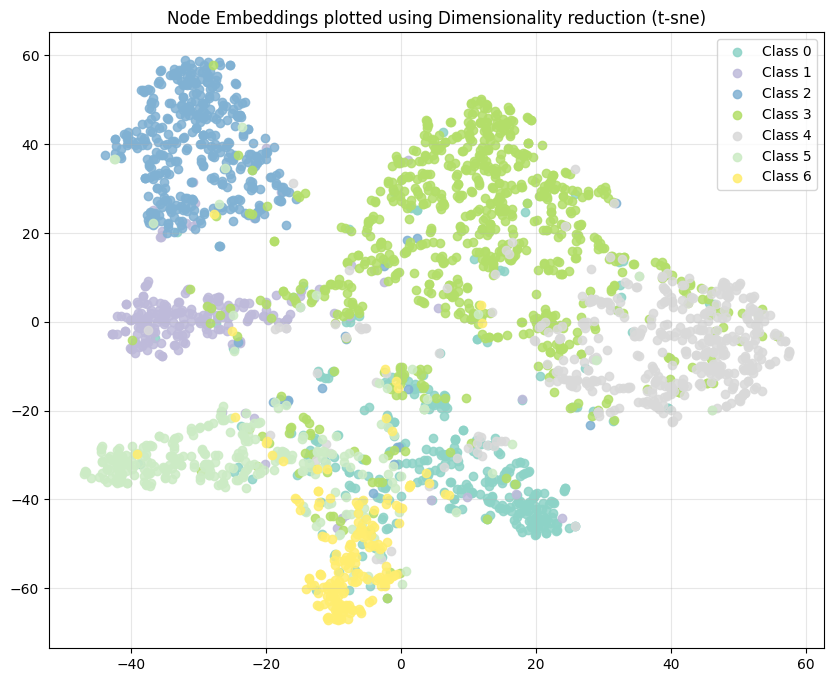

In [9]:
data, num_classes = load_dataset()

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

Graph_nn = GNN(
    inp_dim = data.x.shape[1], # 1433 features for CORA
    hidden_dim = 64,
    out_dim = num_classes,
    num_layers = 2
)
print(f"Number of parameter : {sum(p.numel() for p in Graph_nn.parameters())}\n")
print('Model Architecture:')
print(Graph_nn)
print()

Graph_nn, data = Graph_nn.to(device), data.to(device)

Graph_nn, train_loss, val_accuracy = train(Graph_nn, data, epochs = 200)

visualize_results(train_loss, val_accuracy)
visualize_embed(Graph_nn, data, num_classes)